In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import time
import os



 # These are the classes that are available in the COCO-Dataset
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

c:\Users\combus-rnd\anaconda3\envs\paddle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Load

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

c:\Users\combus-rnd\anaconda3\envs\paddle\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\combus-rnd\anaconda3\envs\paddle\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\combus-rnd/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 56.5MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [42]:
def random_colour_masks(image):

    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, threshold):

    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=1, text_size=1, text_th=1):

    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])),(0, 255, 0), rect_th)
        cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
# We will use the following colors to fill the pixels
colours = [[0, 255, 0],
           [0, 0, 255],
           [255, 0, 0],
           [0, 255, 255],
           [255, 255, 0],
           [255, 0, 255],
           [80, 70, 180],
           [250, 80, 190],
           [245, 145, 50],
           [70, 150, 250],
           [50, 190, 190]]

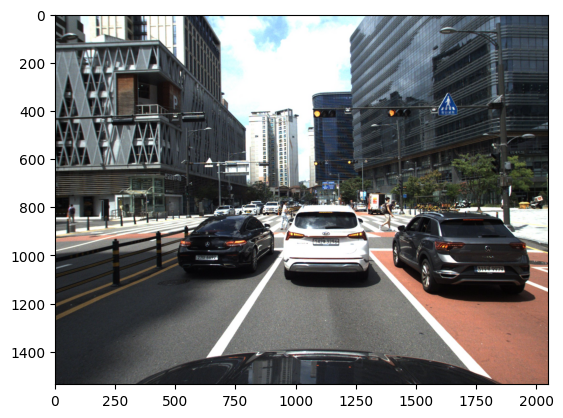

In [5]:
img = Image.open('./test_images/image1.jpg')
plt.imshow(img)
plt.show()

tensor transpose

In [6]:
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
pred = model([img_tensor])

In [18]:
pred[0]['boxes'][0]

tensor([1385.1440,  816.2473, 1986.5389, 1163.0519], grad_fn=<SelectBackward0>)

In [8]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(69, 1536, 2048)

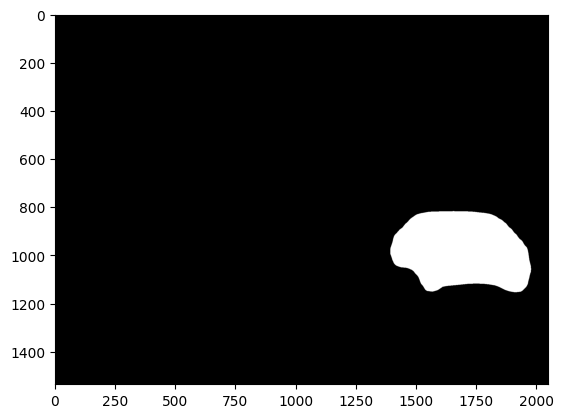

In [40]:
plt.imshow(masks[0], cmap='gray')
plt.show()

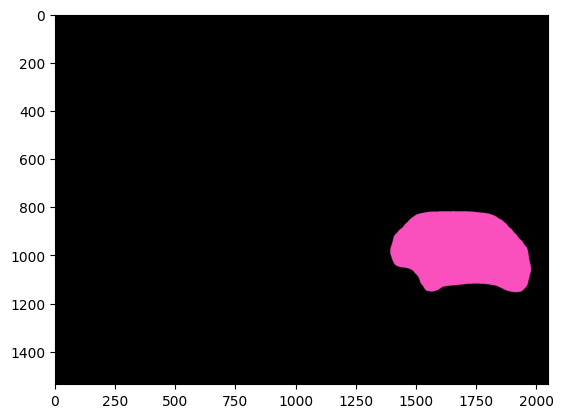

In [10]:
mask1 = random_colour_masks(masks[0])
plt.imshow(mask1)
plt.show()

image + mask blend

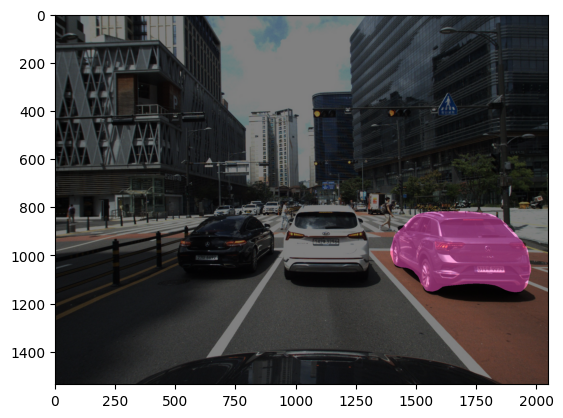

In [11]:
blend_img = cv2.addWeighted(np.asarray(img), 0.5, mask1, 0.5, 0)

plt.imshow(blend_img)
plt.show()

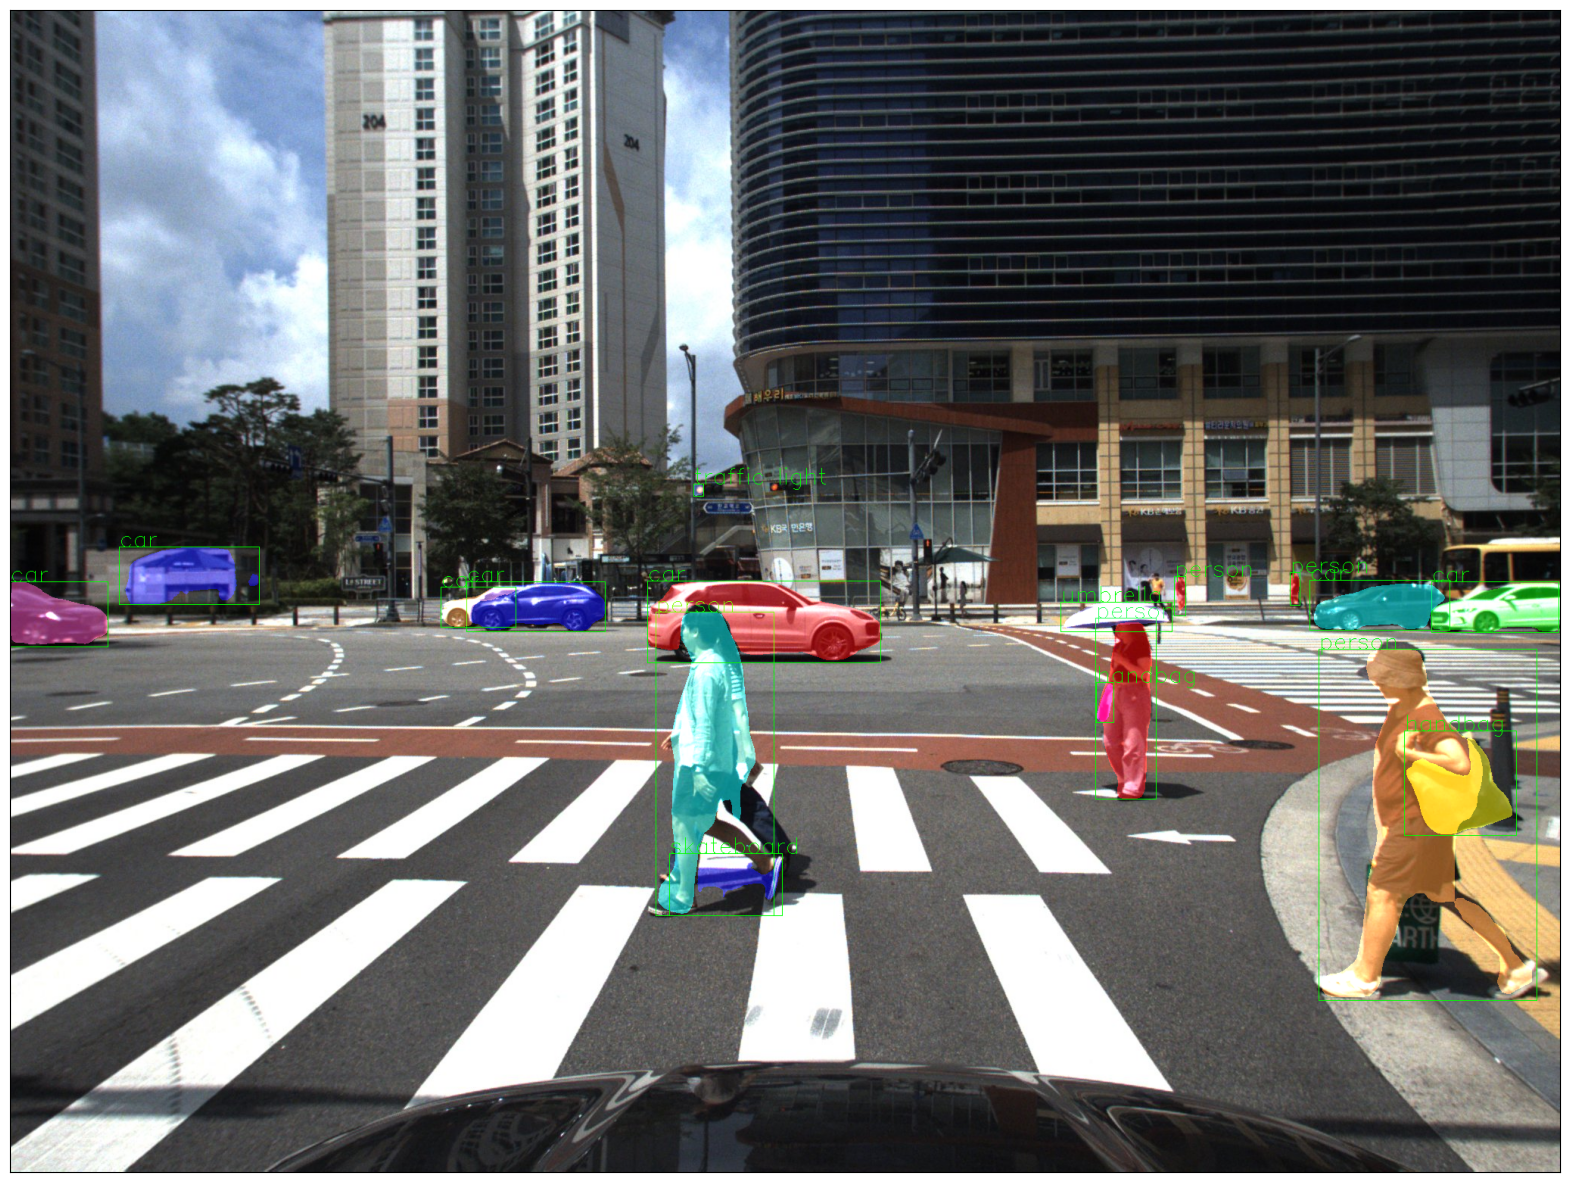

In [43]:
instance_segmentation_api('./test_images/image2.jpg', 0.75)

# 객체 제외한 배경 blur 처리

In [29]:
def check_inference_time(image_path, gpu=False):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    if gpu:
        model.cuda()
        img = img.cuda()
    else:
        model.cpu()
        img = img.cpu()
    start_time = time.time()
    pred = model([img])
    end_time = time.time()
    return end_time-start_time

In [36]:
def pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=1, text_th=2):
    # get the predicted masks and boxes and their corresponding labels
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    # pick the indices belonging to person
    person_ids = [i for i in range(len(pred_cls)) if pred_cls[i]=="person"]
    # pick the masks with the person-ids
    person_masks = masks[person_ids, :, :]
    # create a single mask out of all the instances and clip them
    persons_mask = person_masks.sum(axis=0)
    persons_mask = np.clip(persons_mask, 0,1)
    return persons_mask 

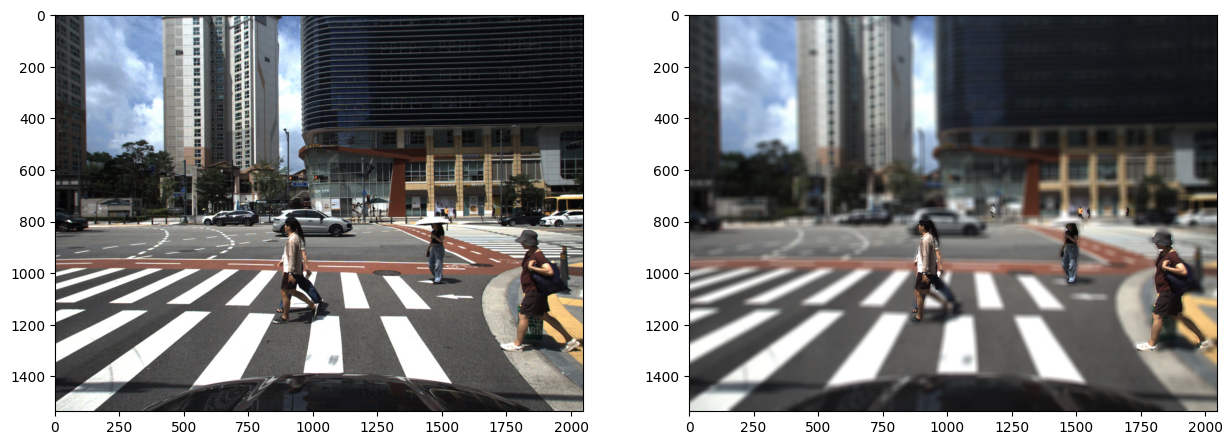

In [45]:
img_path = './test_images/image2.jpg'
img = cv2.imread(img_path)
img_blur = cv2.GaussianBlur(img, (23, 23), 30)

# create the person-mask
person_mask = pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3).astype(np.uint8)
person_mask = np.repeat(person_mask[:, :, None], 3, axis=2)

# finally, create a new image such that pixels where the mask=1, replace it with original image and keep the rest of the pixels
# with blurred image
final_img = np.where(person_mask==1, img, img_blur)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(final_img[:,:,::-1])
plt.show()